# Exploring Obesity Challenge Training Data

This notebook loads and explores the training data from `obesity_challenge_1.h5ad`, examining:
- **X matrix**: Log-normalized gene expression
- **obs metadata**: Cell-level annotations including perturbation labels and program enrichments
- **layers['counts']**: Raw count data
- ~157 perturbations including negative controls (NC)

## 1. Import Required Libraries

In [6]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the AnnData Object

Load the training data from `obesity_challenge_1.h5ad`. We'll use backed mode initially to check the structure without loading everything into memory.

In [7]:
# Load the training data in backed mode (memory-efficient for large files)
# This keeps the data on disk and only loads what's needed
import h5py

data_path = "obesity_challenge_1.h5ad"

# First, use h5py to peek at the file structure without loading
print("=" * 60)
print("Inspecting H5AD File Structure (Memory-Efficient)")
print("=" * 60)

with h5py.File(data_path, 'r') as f:
    print("Top-level groups/datasets:")
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Group):
            print(f"  📁 {key}/ (Group with {len(item)} items)")
        else:
            print(f"  📄 {key}: shape={item.shape}, dtype={item.dtype}")
    
    # Get dimensions from X matrix
    if 'X' in f:
        X = f['X']
        if isinstance(X, h5py.Group):
            # Sparse matrix stored as group
            if 'data' in X:
                print(f"\nX matrix (sparse): {X['data'].shape[0]:,} non-zero values")
            if 'shape' in X.attrs:
                shape = X.attrs['shape']
                print(f"X shape: {shape[0]:,} cells × {shape[1]:,} genes")
        else:
            print(f"\nX matrix: shape={X.shape}")
    
    # Check layers
    if 'layers' in f:
        print(f"\nLayers available: {list(f['layers'].keys())}")

# Now load with scanpy in backed mode
print("\n" + "=" * 60)
print("Loading AnnData in Backed Mode")
print("=" * 60)

adata = sc.read_h5ad(data_path, backed="r")

print(adata)
print(f"\nShape: {adata.shape[0]:,} cells × {adata.shape[1]:,} genes")
print(f"\nAvailable attributes:")
print(f"  - obs columns: {list(adata.obs.columns)}")
print(f"  - var columns: {list(adata.var.columns)}")
print(f"  - layers: {list(adata.layers.keys())}")
print(f"  - obsm keys: {list(adata.obsm.keys()) if adata.obsm else 'None'}")
print(f"  - uns keys: {list(adata.uns.keys()) if adata.uns else 'None'}")

Inspecting H5AD File Structure (Memory-Efficient)
Top-level groups/datasets:
  📁 X/ (Group with 3 items)
  📁 layers/ (Group with 1 items)
  📁 obs/ (Group with 16 items)
  📁 obsm/ (Group with 0 items)
  📁 obsp/ (Group with 0 items)
  📁 uns/ (Group with 1 items)
  📁 var/ (Group with 1 items)
  📁 varm/ (Group with 0 items)
  📁 varp/ (Group with 0 items)

X matrix (sparse): 236,776,088 non-zero values
X shape: 44,846 cells × 11,046 genes

Layers available: ['counts']

Loading AnnData in Backed Mode
AnnData object with n_obs × n_vars = 44846 × 11046 backed at 'obesity_challenge_1.h5ad'
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_guide', 'nFeature_guide', 'percent.mt', 'SampleID', 'Day', 'num_features', 'feature_call', 'num_umis', 'gene', 'adipo', 'pre_adipo', 'other', 'lipo'
    uns: 'log1p'
    layers: 'counts'

Shape: 44,846 cells × 11,046 genes

Available attributes:
  - obs columns: ['nCount_RNA', 'nFeature_RNA', 'nCount_guide', 'nFeature_guide', 'percent.mt', 'SampleID', 'Day', 'num

## 3. Explore the X Matrix (Log-Normalized Expression)

The X matrix contains log-normalized gene expression values. Let's examine its structure and statistics.

In [8]:
# Examine the X matrix using CHUNKED reading for memory efficiency
print("=" * 60)
print("X Matrix (Log-Normalized Expression) - Chunked Analysis")
print("=" * 60)
print(f"Type: {type(adata.X)}")
print(f"Shape: {adata.X.shape}")
print(f"Data type: {adata.X.dtype}")

# Define chunk size for processing
CHUNK_SIZE = 500  # Process 500 cells at a time

# Sample a small subset for quick statistics
np.random.seed(42)
n_sample = min(500, adata.n_obs)
sample_idx = np.random.choice(adata.n_obs, n_sample, replace=False)
sample_idx = np.sort(sample_idx)  # Sort for efficient disk access

print(f"\n--- Loading {n_sample} sampled cells in chunks ---")

# Load sample in chunks to avoid memory issues
X_sample_chunks = []
chunk_starts = range(0, len(sample_idx), CHUNK_SIZE)

for i, start in enumerate(chunk_starts):
    end = min(start + CHUNK_SIZE, len(sample_idx))
    chunk_idx = sample_idx[start:end]
    chunk_data = adata.X[chunk_idx, :]
    if hasattr(chunk_data, 'toarray'):
        chunk_data = chunk_data.toarray()
    X_sample_chunks.append(chunk_data)
    print(f"  Loaded chunk {i+1}/{len(list(chunk_starts))}: cells {start}-{end}")

X_sample = np.vstack(X_sample_chunks)
del X_sample_chunks  # Free memory

print(f"\n--- Statistics from {n_sample:,} sampled cells ---")
print(f"Min value: {X_sample.min():.4f}")
print(f"Max value: {X_sample.max():.4f}")
print(f"Mean value: {X_sample.mean():.4f}")
print(f"Sparsity (% zeros): {(X_sample == 0).sum() / X_sample.size * 100:.2f}%")

# Show a small slice of the data
print(f"\nSample expression values (first 5 cells, first 10 genes):")
print(X_sample[:5, :10])

X Matrix (Log-Normalized Expression) - Chunked Analysis
Type: <class 'anndata._core.sparse_dataset._CSRDataset'>
Shape: (44846, 11046)
Data type: float64

--- Loading 500 sampled cells in chunks ---


  Loaded chunk 1/1: cells 0-500

--- Statistics from 500 sampled cells ---
Min value: 0.0000
Max value: 13.5081
Mean value: 1.2055
Sparsity (% zeros): 52.33%

Sample expression values (first 5 cells, first 10 genes):
[[1.23345652 0.         1.88853603 0.         0.         0.
  2.33739418 0.         0.         1.23345652]
 [1.34808418 0.         3.56317873 1.34808418 0.         0.
  2.03262167 0.         0.         3.12576548]
 [1.88467452 0.         0.         0.         0.         0.
  1.23041702 0.         0.         1.88467452]
 [1.35742831 0.         1.35742831 0.         0.         0.
  1.35742831 0.         0.         1.35742831]
 [1.0442729  0.         1.64369618 0.         1.0442729  0.
  1.0442729  0.         0.         1.64369618]]


## 4. Examine the obs Metadata

The `obs` DataFrame contains cell-level annotations. Let's explore all available columns.

In [9]:
# Explore obs metadata structure
print("=" * 60)
print("obs Metadata Overview")
print("=" * 60)
print(f"Number of cells: {adata.n_obs:,}")
print(f"Number of columns: {len(adata.obs.columns)}")

print("\n--- Column names and data types ---")
for col in adata.obs.columns:
    dtype = adata.obs[col].dtype
    n_unique = adata.obs[col].nunique()
    print(f"  {col}: {dtype} ({n_unique:,} unique values)")

obs Metadata Overview
Number of cells: 44,846
Number of columns: 15

--- Column names and data types ---
  nCount_RNA: int64 (31,853 unique values)
  nFeature_RNA: int64 (4,620 unique values)
  nCount_guide: int64 (721 unique values)
  nFeature_guide: int64 (48 unique values)
  percent.mt: float64 (44,817 unique values)
  SampleID: category (8 unique values)
  Day: category (1 unique values)
  num_features: int64 (1 unique values)
  feature_call: category (601 unique values)
  num_umis: int64 (716 unique values)
  gene: category (123 unique values)
  adipo: int64 (2 unique values)
  pre_adipo: int64 (2 unique values)
  other: int64 (2 unique values)
  lipo: int64 (2 unique values)


In [13]:
# Display sample rows from obs
print("\n--- Sample obs rows (first 10 cells) ---")
adata.obs.head(10)


--- Sample obs rows (first 10 cells) ---


,nCount_RNA,nFeature_RNA,nCount_guide,nFeature_guide,percent.mt,SampleID,Day,num_features,feature_call,num_umis,gene,adipo,pre_adipo,other,lipo
cell,,,,,,,,,,,,,,,
AATF_P1_AACACACCAAGGTCCA-1,6779,2107,41,12,1.047352,TF150_1,Day14,1,AATF_P1P2_JW2,30,AATF,0,0,1,0
AATF_P1_AACGCTATCACCTAGA-1,67952,8001,119,1,3.358253,TF150_1,Day14,1,AATF_P1P2_JW3,119,AATF,0,0,1,0
AATF_P1_AAGGTTAAGATTCACG-1,52474,7595,259,4,7.298853,TF150_1,Day14,1,AATF_P1P2_JW3,256,AATF,1,0,0,0
AATF_P1_AATCGGCTCACTATGG-1,62788,7786,320,4,4.389374,TF150_1,Day14,1,AATF_P1P2_JW3,317,AATF,0,0,1,0
AATF_P1_AATCGTTAGCGATAGG-1,65373,7985,331,6,6.450675,TF150_1,Day14,1,AATF_P1P2_JW3,325,AATF,0,1,0,0
AATF_P1_AATGGGTAGGGTGACA-1,107338,9160,443,8,2.531256,TF150_1,Day14,1,AATF_P1P2_JW3,436,AATF,0,1,0,0
AATF_P1_ACCATTTCACTTAGGG-1,88704,7522,268,5,6.162067,TF150_1,Day14,1,AATF_P1P2_JW2,264,AATF,1,0,0,1
AATF_P1_ACCCGTGAGCCTAGAC-1,71889,8008,298,5,2.797368,TF150_1,Day14,1,AATF_P1P2_JW4,294,AATF,0,0,1,0
AATF_P1_ACCTGGACAATTACTC-1,105663,9383,175,6,3.832941,TF150_1,Day14,1,AATF_P1P2_JW3,170,AATF,1,0,0,0


## 5. Inspect Perturbation Labels and Controls

Identify the perturbation column and analyze the distribution of perturbations, including negative controls (NC).

In [14]:
# Identify perturbation column (likely 'perturbation' or 'gene')
# Look for columns that might contain perturbation info
perturbation_cols = [col for col in adata.obs.columns if 'perturb' in col.lower() or 'gene' in col.lower() or 'target' in col.lower()]
print("Potential perturbation columns:", perturbation_cols)

# Find the main perturbation column
for col in adata.obs.columns:
    unique_vals = adata.obs[col].unique()
    if 'NC' in unique_vals or 'nc' in [str(v).lower() for v in unique_vals]:
        print(f"\nColumn '{col}' contains NC (negative control):")
        print(f"  Unique values: {len(unique_vals)}")

Potential perturbation columns: ['gene']

Column 'gene' contains NC (negative control):
  Unique values: 123


In [15]:
# Analyze perturbation distribution
# The perturbation column is 'gene' (identified above)
perturbation_col = 'gene'

print("=" * 60)
print("Perturbation Analysis")
print("=" * 60)

# Get perturbation counts
perturbation_counts = adata.obs[perturbation_col].value_counts()
print(f"Total unique perturbations: {len(perturbation_counts)}")

# Identify controls
control_label = "NC"
if control_label in perturbation_counts.index:
    n_control = perturbation_counts[control_label]
    print(f"Number of control (NC) cells: {n_control:,}")
    print(f"Number of perturbation conditions (excluding NC): {len(perturbation_counts) - 1}")

print(f"\n--- Cells per perturbation (summary) ---")
print(f"Mean cells per perturbation: {perturbation_counts.mean():.1f}")
print(f"Median cells per perturbation: {perturbation_counts.median():.1f}")
print(f"Min cells per perturbation: {perturbation_counts.min()}")
print(f"Max cells per perturbation: {perturbation_counts.max()}")

# Show top perturbations by cell count
print(f"\n--- Top 10 perturbations by cell count ---")
print(perturbation_counts.head(10))

Perturbation Analysis
Total unique perturbations: 123
Number of control (NC) cells: 8,705
Number of perturbation conditions (excluding NC): 122

--- Cells per perturbation (summary) ---
Mean cells per perturbation: 364.6
Median cells per perturbation: 300.0
Min cells per perturbation: 41
Max cells per perturbation: 8705

--- Top 10 perturbations by cell count ---
gene
NC        8705
ABT1       300
AATF       300
ANKRA2     300
BCL6       300
BDP1       300
BRCA1      300
BTAF1      300
BTG2       300
CBFB       300
Name: count, dtype: int64


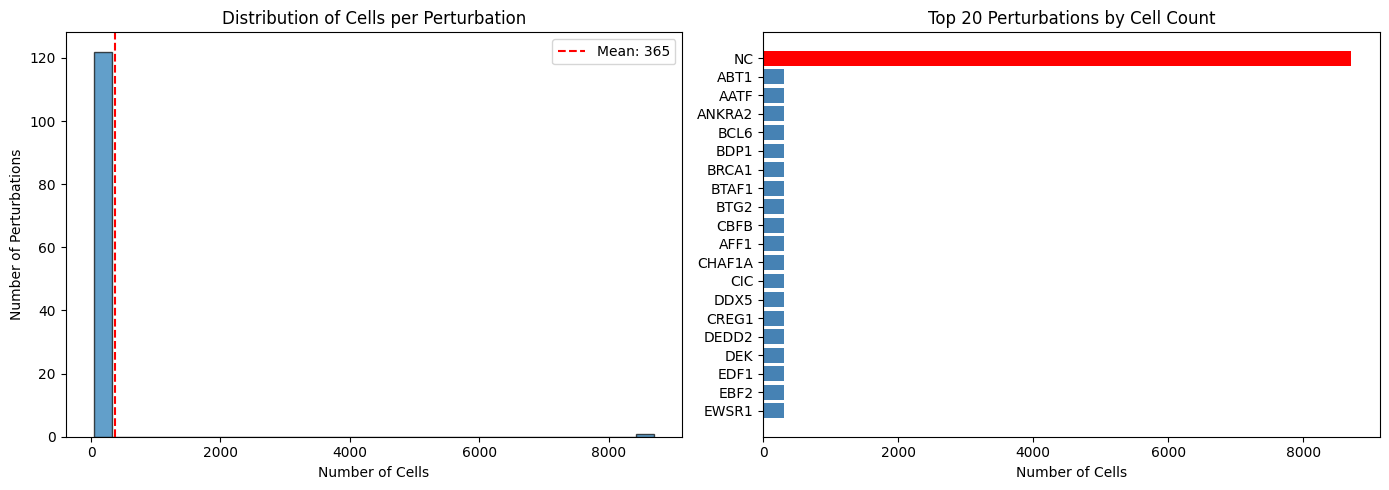


--- All 123 perturbation labels ---
['AATF', 'ABT1', 'AFF1', 'ANKRA2', 'BCL6', 'BDP1', 'BRCA1', 'BTAF1', 'BTG2', 'CBFB', 'CEBPA', 'CEBPB', 'CHAF1A', 'CIC', 'CNOT8', 'CREG1', 'DDX5', 'DEDD2', 'DEK', 'EBF2', 'EDF1', 'EEF1A1', 'EP300', 'EP400', 'ETV1', 'EWSR1', 'FAM136A', 'FASN', 'FLI1', 'FOS', 'FOXP1', 'FOXP2', 'GRB14', 'HAND2', 'HAX1', 'HDAC2', 'HIF1A', 'HIF3A', 'HMBOX1', 'HMGA1', 'HMGN3', 'IRF4', 'JARID2', 'KLF15', 'KLF16', 'KLF4', 'KLF5', 'KLF7', 'MBD3', 'MEF2A', 'MEIS2', 'MXD1', 'NAB1', 'NC', 'NCOR2', 'NFE2L1', 'NFIA', 'NFIB', 'NHLH1', 'NKX3-1', 'NMI', 'NPM1', 'NR3C1', 'NR4A2', 'NRIP1', 'PBX1', 'PBX3', 'PDCD11', 'PDLIM4', 'PHF3', 'PIAS4', 'PLAGL1', 'PLIN1', 'POLR2B', 'PPARA', 'PPARD', 'PWP1', 'RB1', 'RBAK', 'RBBP7', 'REXO4', 'RNASEH2C', 'RORA', 'RREB1', 'RUNX1', 'RXRG', 'SMAD2', 'SMARCA4', 'SOX13', 'SRPK1', 'SSB', 'SUPT5H', 'TCEAL1', 'TCERG1', 'TCF7L2', 'TCFL5', 'TEAD1', 'TFAP2A', 'TFEB', 'TMEM107', 'TRPS1', 'TRRAP', 'TSC22D1', 'TSHZ2', 'TWIST1', 'TWIST2', 'ZFP2', 'ZFPM2', 'ZFY', 'Z

In [24]:
# Visualize perturbation distribution
import os

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of cells per perturbation
axes[0].hist(perturbation_counts.values, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Cells')
axes[0].set_ylabel('Number of Perturbations')
axes[0].set_title('Distribution of Cells per Perturbation')
axes[0].axvline(perturbation_counts.mean(), color='red', linestyle='--', label=f'Mean: {perturbation_counts.mean():.0f}')
axes[0].legend()

# Bar plot of top perturbations
top_n = 20
top_perturbations = perturbation_counts.head(top_n)
colors = ['red' if x == 'NC' else 'steelblue' for x in top_perturbations.index]
axes[1].barh(range(len(top_perturbations)), top_perturbations.values, color=colors)
axes[1].set_yticks(range(len(top_perturbations)))
axes[1].set_yticklabels(top_perturbations.index)
axes[1].set_xlabel('Number of Cells')
axes[1].set_title(f'Top {top_n} Perturbations by Cell Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/perturbation_distribution.png', dpi=300)
plt.show()

# List all perturbation labels
print(f"\n--- All {len(perturbation_counts)} perturbation labels ---")
print(sorted(perturbation_counts.index.tolist()))

## 6. Analyze Program Enrichments

Explore program enrichment columns in obs metadata. These may represent cell type proportions or pathway enrichment scores.

In [17]:
# Identify program enrichment columns
# Look for columns with 'program', 'score', 'enrichment', or cell type names
enrichment_cols = [col for col in adata.obs.columns if any(
    keyword in col.lower() for keyword in ['program', 'score', 'enrich', 'adipocyte', 'lipogenic', 'pre-adipo', 'preadipo']
)]

# Also look for numeric columns that might be enrichment scores
numeric_cols = adata.obs.select_dtypes(include=[np.number]).columns.tolist()

print("=" * 60)
print("Program Enrichment Analysis")
print("=" * 60)
print(f"Potential enrichment columns: {enrichment_cols}")
print(f"\nAll numeric columns: {numeric_cols}")

# Display statistics for numeric columns
print("\n--- Numeric column statistics ---")
adata.obs[numeric_cols].describe()

Program Enrichment Analysis
Potential enrichment columns: []

All numeric columns: ['nCount_RNA', 'nFeature_RNA', 'nCount_guide', 'nFeature_guide', 'percent.mt', 'num_features', 'num_umis', 'adipo', 'pre_adipo', 'other', 'lipo']

--- Numeric column statistics ---


,nCount_RNA,nFeature_RNA,nCount_guide,nFeature_guide,percent.mt,num_features,num_umis,adipo,pre_adipo,other,lipo
count,44846.000000,44846.000000,44846.000000,44846.000000,44846.000000,44846.0,44846.000000,44846.000000,44846.000000,44846.000000,44846.000000
mean,71889.424140,7959.061700,198.429715,5.746421,4.285996,1.0,193.529679,0.269255,0.379298,0.351447,0.078647
std,19774.216522,954.792264,105.818732,2.984549,1.641188,0.0,105.539732,0.443578,0.485218,0.477428,0.269190
min,543.000000,398.000000,8.000000,1.000000,0.034116,1.0,5.000000,0.000000,0.000000,0.000000,0.000000
25%,60143.250000,7561.000000,127.000000,4.000000,3.196673,1.0,123.000000,0.000000,0.000000,0.000000,0.000000
50%,69629.500000,8031.000000,185.000000,5.000000,4.072079,1.0,180.000000,0.000000,0.000000,0.000000,0.000000
75%,81544.000000,8489.000000,254.000000,7.000000,5.114288,1.0,249.000000,1.000000,1.000000,1.000000,0.000000
max,196008.000000,11606.000000,1660.000000,75.000000,14.851006,1.0,1656.000000,1.000000,1.000000,1.000000,1.000000



Potential program enrichment columns: ['adipo', 'pre_adipo', 'other', 'lipo']


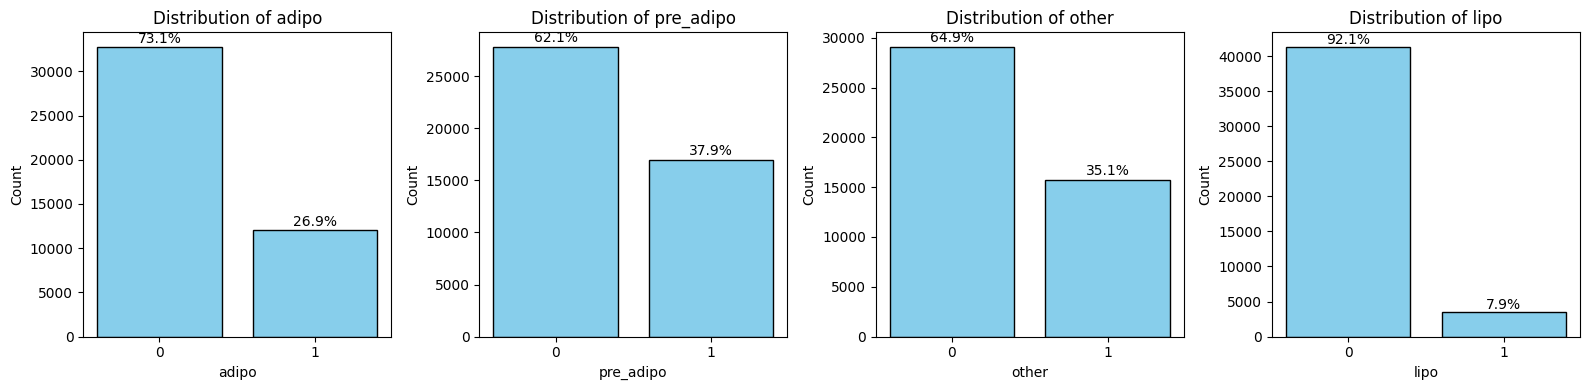

In [25]:
# If there are enrichment/program columns, visualize them
if len(numeric_cols) > 0:
    # Select columns that look like enrichment scores
    # Filter for columns that are likely 0/1 binary labels or scores
    program_cols = [col for col in numeric_cols if col in ['adipo', 'pre_adipo', 'other', 'lipo'] or (adata.obs[col].nunique() < 10 and adata.obs[col].nunique() > 1)]
    
    if len(program_cols) > 0:
        print(f"\nPotential program enrichment columns: {program_cols}")
        
        # Visualize distribution of cell states
        n_cols = len(program_cols)
        if n_cols > 0:
            fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 4))
            if n_cols == 1:
                axes = [axes]
            
            for ax, col in zip(axes, program_cols):
                # For binary/categorical data, bar plot is better than hist
                counts = adata.obs[col].value_counts().sort_index()
                ax.bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
                ax.set_xlabel(col)
                ax.set_ylabel('Count')
                ax.set_title(f'Distribution of {col}')
                
                # Add percentages
                total = counts.sum()
                for i, v in enumerate(counts.values):
                    ax.text(i, v + total*0.01, f'{v/total*100:.1f}%', ha='center')
            
            plt.tight_layout()
            plt.savefig('figures/program_enrichment.png', dpi=300)
            plt.show()
    else:
        print("No obvious enrichment columns found. Displaying all numeric columns.")

## 7. Access Raw Counts from Layers

Access `layers['counts']` containing raw count data and compare to the normalized X matrix.

In [19]:
# Explore the layers using CHUNKED reading
print("=" * 60)
print("Raw Counts Layer Analysis - Chunked")
print("=" * 60)
print(f"Available layers: {list(adata.layers.keys())}")

if 'counts' in adata.layers:
    counts_layer = adata.layers['counts']
    print(f"\nlayers['counts'] info:")
    print(f"  Type: {type(counts_layer)}")
    print(f"  Shape: {counts_layer.shape}")
    print(f"  Data type: {counts_layer.dtype}")
    
    # Load counts sample in chunks (reusing sample_idx from earlier)
    print(f"\n--- Loading {len(sample_idx):,} sampled cells in chunks ---")
    counts_chunks = []
    chunk_starts = range(0, len(sample_idx), CHUNK_SIZE)
    
    for i, start in enumerate(chunk_starts):
        end = min(start + CHUNK_SIZE, len(sample_idx))
        chunk_idx = sample_idx[start:end]
        chunk_data = counts_layer[chunk_idx, :]
        if hasattr(chunk_data, 'toarray'):
            chunk_data = chunk_data.toarray()
        counts_chunks.append(chunk_data)
        print(f"  Loaded chunk {i+1}/{len(list(chunk_starts))}")
    
    counts_sample = np.vstack(counts_chunks)
    del counts_chunks  # Free memory
    
    print(f"\n--- Statistics from {len(sample_idx):,} sampled cells ---")
    print(f"  Min value: {counts_sample.min():.0f}")
    print(f"  Max value: {counts_sample.max():.0f}")
    print(f"  Mean value: {counts_sample.mean():.4f}")
    print(f"  Sparsity (% zeros): {(counts_sample == 0).sum() / counts_sample.size * 100:.2f}%")
    
    # Check if values are integers (raw counts)
    is_integer = np.allclose(counts_sample, counts_sample.astype(int))
    print(f"  Values are integers: {is_integer}")
    
    print(f"\nSample raw counts (first 5 cells, first 10 genes):")
    print(counts_sample[:5, :10])
else:
    print("'counts' layer not found. Available layers:", list(adata.layers.keys()))

Raw Counts Layer Analysis - Chunked
Available layers: ['counts']

layers['counts'] info:
  Type: <class 'scipy.sparse._csr.csr_matrix'>
  Shape: (44846, 11046)
  Data type: float64

--- Loading 500 sampled cells in chunks ---
  Loaded chunk 1/1

--- Statistics from 500 sampled cells ---
  Min value: 0
  Max value: 7268
  Mean value: 4.2160
  Sparsity (% zeros): 52.33%
  Values are integers: True

Sample raw counts (first 5 cells, first 10 genes):
[[1. 0. 2. 0. 0. 0. 3. 0. 0. 1.]
 [1. 0. 7. 1. 0. 0. 2. 0. 0. 5.]
 [2. 0. 0. 0. 0. 0. 1. 0. 0. 2.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 2. 0. 1. 0. 1. 0. 0. 2.]]


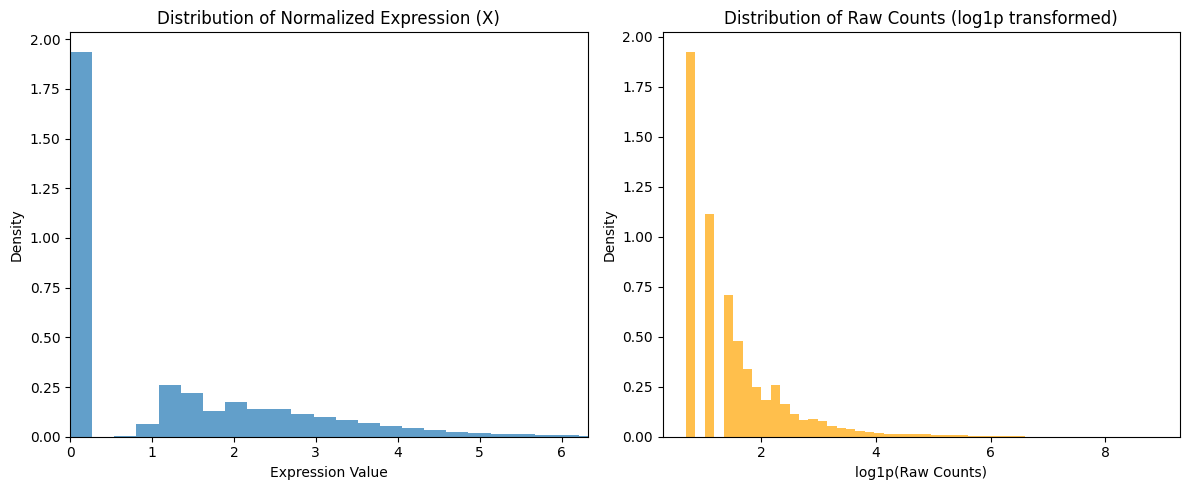

In [26]:
# Compare normalized X vs raw counts for same cells
if 'counts' in adata.layers:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Distribution of expression values
    axes[0].hist(X_sample.flatten(), bins=50, alpha=0.7, label='Normalized (X)', density=True)
    axes[0].set_xlabel('Expression Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distribution of Normalized Expression (X)')
    axes[0].set_xlim(0, np.percentile(X_sample, 99))
    
    # Distribution of raw counts (log scale for visualization)
    counts_nonzero = counts_sample[counts_sample > 0]
    axes[1].hist(np.log1p(counts_nonzero), bins=50, alpha=0.7, color='orange', density=True)
    axes[1].set_xlabel('log1p(Raw Counts)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution of Raw Counts (log1p transformed)')
    
    plt.tight_layout()
    plt.savefig('figures/counts_distribution.png', dpi=300)
    plt.show()

## 8. Summarize Perturbation Statistics

Generate a comprehensive summary table with cell counts and expression statistics per perturbation.

In [21]:
# Create summary table for all perturbations
print("=" * 60)
print("Perturbation Summary Table")
print("=" * 60)

# Group by perturbation and compute statistics
summary_data = []

for pert in adata.obs[perturbation_col].unique():
    mask = adata.obs[perturbation_col] == pert
    n_cells = mask.sum()
    
    # Get any numeric metadata for this perturbation group
    pert_obs = adata.obs[mask]
    
    row = {
        'perturbation': pert,
        'n_cells': n_cells,
        'is_control': pert == control_label
    }
    
    # Add mean values for numeric columns
    for col in numeric_cols[:5]:  # Limit to first 5 numeric columns
        row[f'{col}_mean'] = pert_obs[col].mean()
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('n_cells', ascending=False).reset_index(drop=True)

print(f"Total perturbations: {len(summary_df)}")
print(f"Control (NC): {(summary_df['is_control']).sum()}")
print(f"Gene perturbations: {(~summary_df['is_control']).sum()}")

# Display the summary table
summary_df.head(20)

Perturbation Summary Table
Total perturbations: 123
Control (NC): 1
Gene perturbations: 122


,perturbation,n_cells,is_control,nCount_RNA_mean,nFeature_RNA_mean,nCount_guide_mean,nFeature_guide_mean,percent.mt_mean
0,NC,8705,True,72696.959449,7990.978288,202.752211,5.874095,4.412185
1,ABT1,300,False,72961.143333,7992.823333,198.896667,5.530000,4.144437
2,AATF,300,False,70993.106667,7937.456667,206.593333,5.683333,4.532362
3,ANKRA2,300,False,71579.360000,7912.670000,196.066667,5.556667,4.697819
4,BCL6,300,False,70330.326667,7924.736667,200.333333,6.783333,4.325040
5,BDP1,300,False,71953.646667,7910.573333,177.243333,5.706667,4.185795
6,BRCA1,300,False,70477.763333,7889.903333,212.980000,5.560000,4.192610
7,BTAF1,300,False,71702.033333,7960.083333,200.760000,5.823333,4.337894
8,BTG2,300,False,71419.323333,8048.440000,163.106667,6.106667,4.352516
9,CBFB,300,False,69740.936667,7933.026667,203.753333,5.346667,4.339677


In [22]:
# Also examine the var (gene) metadata
print("=" * 60)
print("Gene (var) Metadata")
print("=" * 60)
print(f"Number of genes: {adata.n_vars:,}")
print(f"var columns: {list(adata.var.columns)}")

# Display sample of var
print("\n--- Sample gene annotations ---")
adata.var.head(10)

Gene (var) Metadata
Number of genes: 11,046
var columns: []

--- Sample gene annotations ---


""
gene
MEX3D
LNCTAM34A
NIBAN1
ARHGEF28
PER2
KCNJ2
HDAC7
KCNIP2-AS1
ARMC7


In [23]:
# Final summary
print("=" * 60)
print("FINAL DATA SUMMARY")
print("=" * 60)
print(f"""
Dataset: obesity_challenge_1.h5ad
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Dimensions:
  • Cells: {adata.n_obs:,}
  • Genes: {adata.n_vars:,}

Data matrices:
  • X (normalized): {type(adata.X).__name__}, dtype={adata.X.dtype}
  • layers['counts']: {'Available' if 'counts' in adata.layers else 'Not found'}

Perturbations:
  • Total conditions: {len(perturbation_counts)}
  • Control cells (NC): {perturbation_counts.get('NC', 'N/A'):,}
  • Gene perturbations: {len(perturbation_counts) - 1}

Metadata columns:
  • obs (cell): {len(adata.obs.columns)} columns
  • var (gene): {len(adata.var.columns)} columns
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

FINAL DATA SUMMARY

Dataset: obesity_challenge_1.h5ad
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Dimensions:
  • Cells: 44,846
  • Genes: 11,046

Data matrices:
  • X (normalized): _CSRDataset, dtype=float64
  • layers['counts']: Available

Perturbations:
  • Total conditions: 123
  • Control cells (NC): 8,705
  • Gene perturbations: 122

Metadata columns:
  • obs (cell): 15 columns
  • var (gene): 0 columns
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

